In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor
from lightgbm import plot_importance
from sklearn.metrics import mean_squared_error

In [10]:
sns.set(style="whitegrid")
df = pd.read_csv("options_KR.csv", parse_dates=["Date"], index_col="Date")
df["For_KOSPI_Netbuying_Amount"] = df["For_KOSPI_Netbuying_Amount"].apply(
    lambda x: int(float(x))
)
predictors = df.columns[1:].tolist()
df = pd.get_dummies(df, columns=["Day_of_a_week"])
predictors = df.columns[1:].tolist()

RMSE = lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred))


def split_time_dataset(X, y, train_ratio):
    assert X.shape[0] == len(y)

    n = X.shape[0]
    index = round(n * train_ratio)

    X_train, X_test = X.iloc[:index,], X.iloc[index:,]
    y_train, y_test = y[:index], y[index:]

    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = split_time_dataset(df[predictors], df["VKOSPI"], 0.8)
RMSE = lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred))

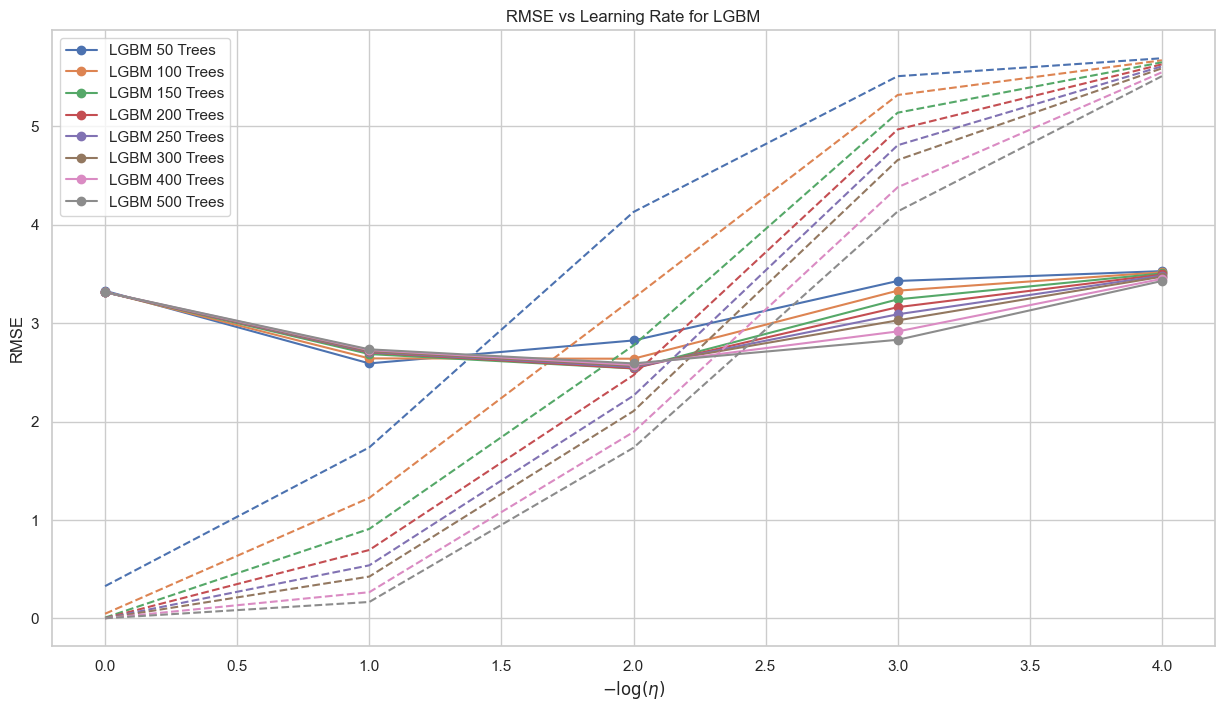

In [11]:
performances = []
n_estimators_options = [50, 100, 150, 200, 250, 300, 400, 500]

learning_rate_options = [10 ** (-power) for power in range(0, 5)]

best_rmse = float("inf")
best_alpha = None
best_l1_ratio = None

for n_estimators in n_estimators_options:
    performance = {
        "Trees": n_estimators,
        "performances_train": [],
        "performances_test": [],
    }
    for learning_rate in learning_rate_options:
        model = LGBMRegressor(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            random_state=42,
            verbose=-1,
        )
        model.fit(X_train, y_train)

        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        rmse = RMSE(y_train, y_pred_train)

        if rmse < best_rmse:
            best_rmse = rmse
            best_alpha = alpha
            best_l1_ratio = l1_ratio

        performance["performances_train"].append(RMSE(y_train, y_pred_train))
        performance["performances_test"].append(RMSE(y_test, y_pred_test))

    performances.append(performance)

plt.figure(figsize=(15, 8))
learning_rate_powers = -np.log10(learning_rate_options)

for index, performance in enumerate(performances):
    color = sns.color_palette()[index]
    plt.plot(
        learning_rate_powers,
        performance["performances_test"],
        "o-",
        label=f"LGBM {performance['Trees']} Trees",
        color=color,
    )
    plt.plot(learning_rate_powers, performance["performances_train"], "--", color=color)

plt.xlabel(r"$-\log(\eta)$")
plt.ylabel("RMSE")
plt.title("RMSE vs Learning Rate for LGBM")
plt.legend()
plt.show()

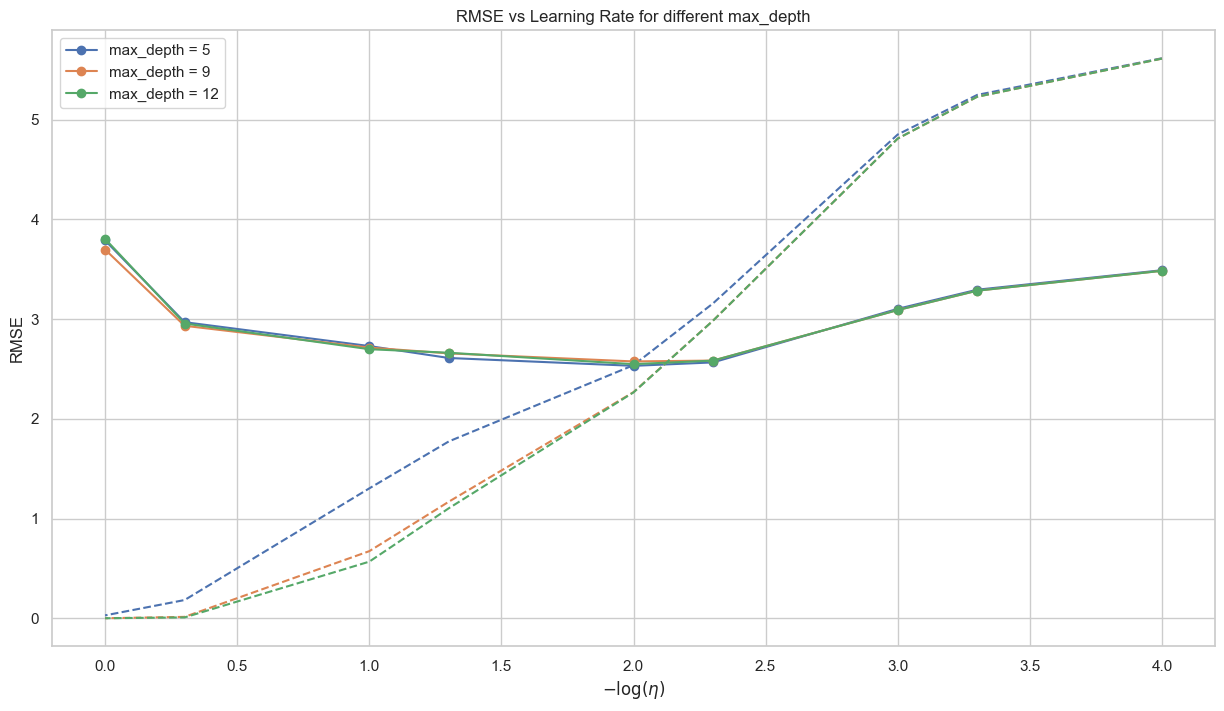

In [14]:
def compute_performance(learning_rates, parameter_name, parameter_values, **parameters):
    performances = []
    for parameter_value in parameter_values:
        train_rmse = []
        test_rmse = []
        for learning_rate in learning_rates:
            parameters["learning_rate"] = learning_rate
            parameters[parameter_name] = parameter_value
            model = LGBMRegressor(**parameters)
            model.fit(X_train, y_train)

            y_pred_train = model.predict(X_train)
            y_pred_test = model.predict(X_test)

            train_rmse.append(RMSE(y_train, y_pred_train))
            test_rmse.append(RMSE(y_test, y_pred_test))

        performances.append(
            {
                parameter_name: parameter_value,
                "train_rmse": train_rmse,
                "test_rmse": test_rmse,
            }
        )
    return performances


learning_rates = [10 ** (-power) for power in range(0, 5)] + [
    5 * 10 ** (-power) for power in range(1, 5)
]
learning_rates.sort()

max_depth_values = [5, 9, 12]
performances = compute_performance(
    learning_rates=learning_rates,
    parameter_name="max_depth",
    parameter_values=max_depth_values,
    n_estimators=250,
)

plt.figure(figsize=(15, 8))
learning_rate_powers = -np.log10(learning_rates)

for index, performance in enumerate(performances):
    color = sns.color_palette()[index]
    plt.plot(
        learning_rate_powers,
        performance["test_rmse"],
        "o-",
        label=f"max_depth = {performance['max_depth']}",
        color=color,
    )
    plt.plot(learning_rate_powers, performance["train_rmse"], "--", color=color)

plt.xlabel(r"$-\log(\eta)$")
plt.ylabel("RMSE")
plt.title("RMSE vs Learning Rate for different max_depth")
plt.legend()
plt.show()

<Figure size 1500x800 with 0 Axes>

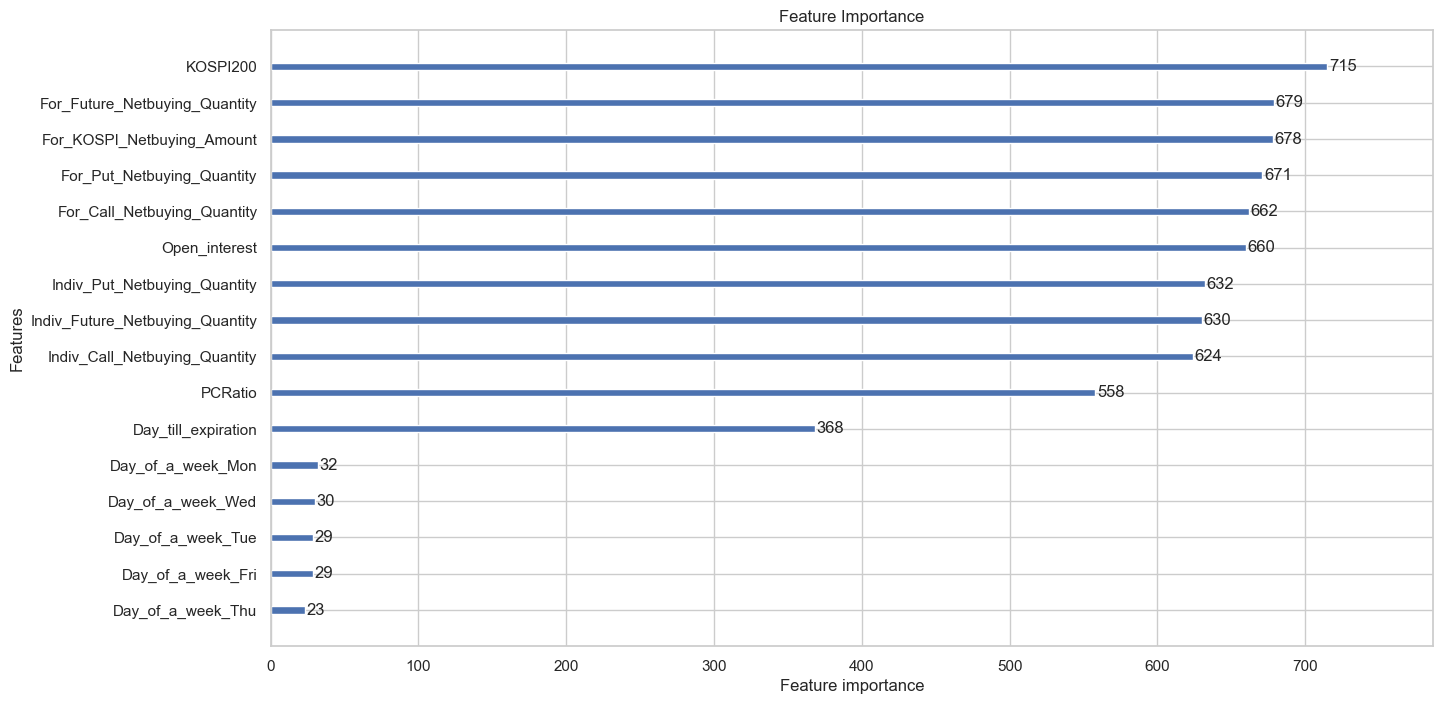

In [13]:
model = LGBMRegressor(n_estimators=250, learning_rate=0.5, max_depth=9)
model.fit(X_train, y_train)

plt.figure(figsize=(15, 8))
plot_importance(model, figsize=(15, 8))
plt.title("Feature Importance")
plt.show()

## Best params

n_estimators: 500, learning_rate: 0.0001, max_depth: 12
